<a href="https://colab.research.google.com/github/shashankbhagat/Earthquake-Prediction/blob/master/EarthQuake_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns',None)

In [2]:
data=pd.read_csv('database.csv')
data.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,1/2/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,1/4/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,1/5/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,1/8/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,1/9/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [3]:
data.dtypes

Date                           object
Time                           object
Latitude                      float64
Longitude                     float64
Type                           object
Depth                         float64
Depth Error                   float64
Depth Seismic Stations        float64
Magnitude                     float64
Magnitude Type                 object
Magnitude Error               float64
Magnitude Seismic Stations    float64
Azimuthal Gap                 float64
Horizontal Distance           float64
Horizontal Error              float64
Root Mean Square              float64
ID                             object
Source                         object
Location Source                object
Magnitude Source               object
Status                         object
dtype: object

# Data Analysis

Before starting with the analysis, we would be scaling the input. Espicially the Date and Time fields to Unix time which is in seconds.

In [4]:
import datetime
import time

timestamp=[]
for d,t in zip(data['Date'],data['Time']):
    try:
        ts=datetime.datetime.strptime(d+' '+t,'%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        timestamp.append('ValueError')

In [5]:
timestamp.count('ValueError')

0

In [6]:
data['TimeStamp']=timestamp
data.drop(columns=['Date','Time'],axis=1,inplace=True)
data.head()

,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,TimeStamp
0,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,-157630542.0
1,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,-157465811.0
2,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,-157355642.0
3,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,-157093817.0
4,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,-157026430.0


In [7]:
data.dtypes

Latitude                      float64
Longitude                     float64
Type                           object
Depth                         float64
Depth Error                   float64
Depth Seismic Stations        float64
Magnitude                     float64
Magnitude Type                 object
Magnitude Error               float64
Magnitude Seismic Stations    float64
Azimuthal Gap                 float64
Horizontal Distance           float64
Horizontal Error              float64
Root Mean Square              float64
ID                             object
Source                         object
Location Source                object
Magnitude Source               object
Status                         object
TimeStamp                     float64
dtype: object

Missing Values

In [8]:
## list of features with NA
features_with_na=[feature for feature in data.columns if data[feature].isnull().sum()>0]

for feature in features_with_na:
    print(feature,np.round(data[feature].isnull().sum()/len(data[feature])*100,4),' %missing values')

Depth Error 80.9457  %missing values
Depth Seismic Stations 69.6865  %missing values
Magnitude Type 0.0128  %missing values
Magnitude Error 98.6033  %missing values
Magnitude Seismic Stations 89.0484  %missing values
Azimuthal Gap 68.8237  %missing values
Horizontal Distance 93.1488  %missing values
Horizontal Error 95.0624  %missing values
Root Mean Square 25.8842  %missing values


In [9]:
## Features having missing values for more than 50%. So we must drop those features.
for feature in features_with_na:
    if (data[feature].isnull().sum()/len(data[feature]))*100>50:
        data.drop(columns=feature,inplace=True)

data.drop(columns=['ID'],inplace=True)

data.head()

,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,Source,Location Source,Magnitude Source,Status,TimeStamp
0,19.246,145.616,Earthquake,131.6,6.0,MW,NaN,ISCGEM,ISCGEM,ISCGEM,Automatic,-157630542.0
1,1.863,127.352,Earthquake,80.0,5.8,MW,NaN,ISCGEM,ISCGEM,ISCGEM,Automatic,-157465811.0
2,-20.579,-173.972,Earthquake,20.0,6.2,MW,NaN,ISCGEM,ISCGEM,ISCGEM,Automatic,-157355642.0
3,-59.076,-23.557,Earthquake,15.0,5.8,MW,NaN,ISCGEM,ISCGEM,ISCGEM,Automatic,-157093817.0
4,11.938,126.427,Earthquake,15.0,5.8,MW,NaN,ISCGEM,ISCGEM,ISCGEM,Automatic,-157026430.0


In [10]:
## updated list of features with NA
features_with_na=[feature for feature in data.columns if data[feature].isnull().sum()>0]
features_with_na

['Magnitude Type', 'Root Mean Square']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


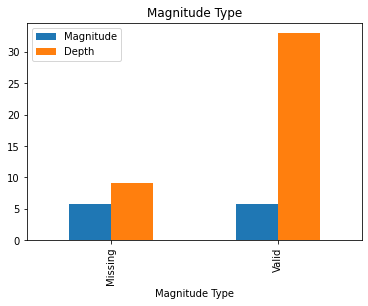

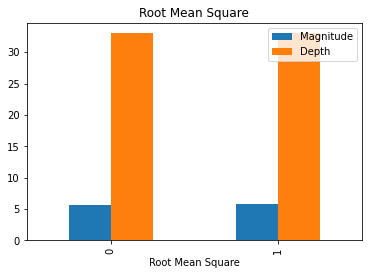

In [11]:
## Relation between remaining valid NA features and dependent feature

for feature in features_with_na:
    data_temp=data.copy()
    if data_temp[feature].dtype=='O':
        data_temp[feature]=np.where(data_temp[feature].isnull(),'Missing','Valid')
    else:
        data_temp[feature]=np.where(data_temp[feature].isnull(),1,0)

    data_temp.groupby(data_temp[feature])['Magnitude','Depth'].median().plot.bar()
    plt.title(feature)
    plt.show()


Here the missing values are significant compared to the Magnitude (dependent feature). So the decision to directly drop them would not be good. So, we would check in feature engineering and feature selection process.

In [12]:
data.dtypes

Latitude            float64
Longitude           float64
Type                 object
Depth               float64
Magnitude           float64
Magnitude Type       object
Root Mean Square    float64
Source               object
Location Source      object
Magnitude Source     object
Status               object
TimeStamp           float64
dtype: object

In [13]:
for feature in data.columns:
    if data[feature].dtype != 'O':
        print(feature,':',len(data[feature].unique()))

Latitude : 20676
Longitude : 21474
Depth : 3485
Magnitude : 64
Root Mean Square : 191
TimeStamp : 23393


We can see from the above result that Latitude, Longitude and Root Mean Square are continuous features. Still while plotting we would use a threshold for unique values to check.

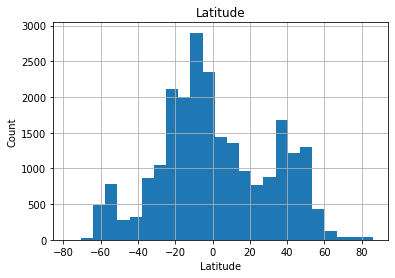

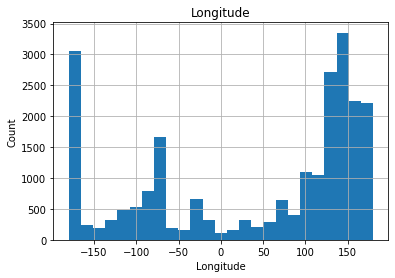

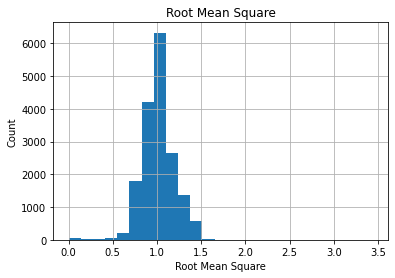

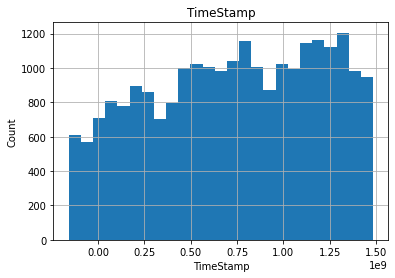

In [14]:
for feature in data.columns:
    if data[feature].dtype != 'O' and feature not in ['Depth','Magnitude']:
        if len(data[feature].unique())<25:
            ## Discrete feature
            ## Bar plots
            data.groupby(feature)['Depth','Magnitude'].median().plot.bar()
            plt.xlabel(feature)
            plt.ylabel('median of Magnitude and Depth')
            plt.title(feature)
            plt.show()

        else:
            ## Continuous feature
            ## Histogram
            data[feature].hist(bins=25)
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.title(feature)
            plt.show()

The feature Longitude seems to be non-Guassian. Let's try to fix it by perform log normalisation on it.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


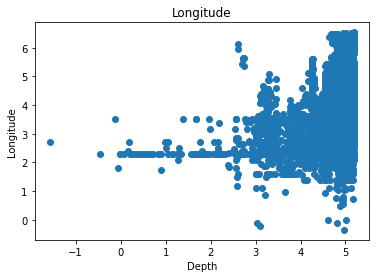

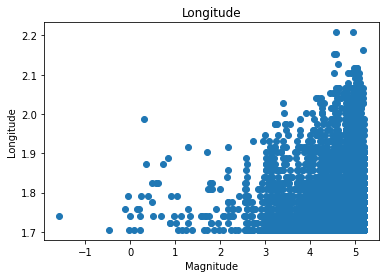

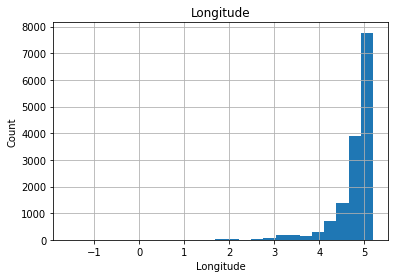

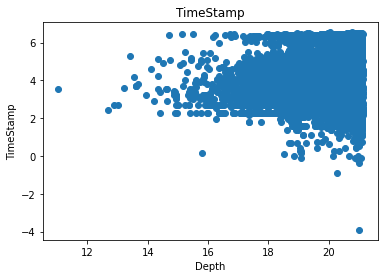

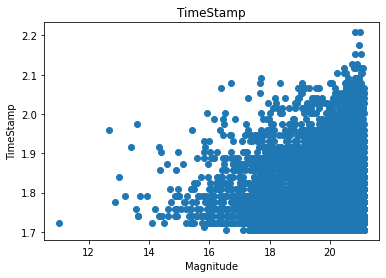

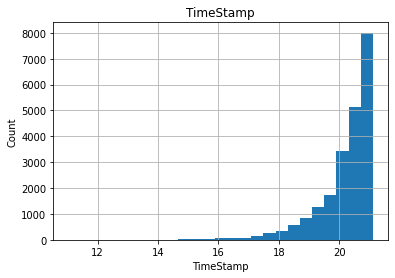

In [15]:
for feature in data.columns:
    if data[feature].dtype != 'O' and feature not in ['Depth','Magnitude']:
        if 0 not in data[feature].unique():
            temp=data.copy()
            temp[feature]=np.log(temp[feature])
            temp['Depth']=np.log(temp['Depth'])
            temp['Magnitude']=np.log(temp['Magnitude'])

            plt.scatter(temp[feature],temp['Depth'])
            plt.xlabel('Depth')
            plt.ylabel(feature)
            plt.title(feature)
            plt.show()

            plt.scatter(temp[feature],temp['Magnitude'])
            plt.xlabel('Magnitude')
            plt.ylabel(feature)
            plt.title(feature)
            plt.show()

            temp[feature].hist(bins=25)
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.title(feature)
            plt.show()


From above histogram, we can see that Log normalisation did not fix the problem but made it worse by right-skewing the data. As it is a Regression problem data, let's try to train and test the model first and verify the variance and bias (train and test error).

Let's check for outliers for continuous features.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


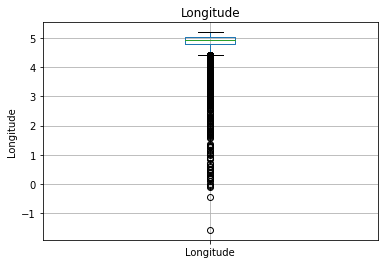

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


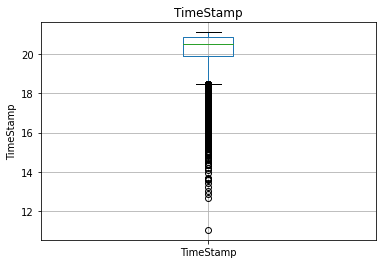

In [16]:
for feature in data.columns:
    if data[feature].dtype != 'O' and feature not in ['Depth','Magnitude']:
        if 0 not in data[feature].unique():
            temp=data.copy()
            temp[feature]=np.log(temp[feature])
            temp['Depth']=np.log(temp['Depth'])
            temp['Magnitude']=np.log(temp['Magnitude'])

            temp.boxplot(column=feature)
            plt.ylabel(feature)
            plt.title(feature)
            plt.show()

From above box plot, we can see that as previously discussed log normalisation is making the data worse and skewed which is visible from the box plot as well.

Categorical Features

In [17]:
## checking the number of unique features for categorical features

for feature in data.columns:
    if data[feature].dtype=='O':
        print('{}: {} unique categories'.format(feature,len(data[feature].unique())))


Type: 4 unique categories
Magnitude Type: 11 unique categories
Source: 13 unique categories
Location Source: 48 unique categories
Magnitude Source: 24 unique categories
Status: 2 unique categories


Finding the relation between the categorical features and the dependent features (Magnitude, Depth).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


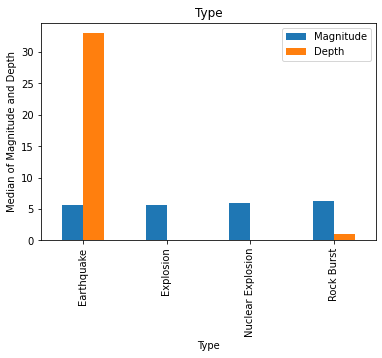

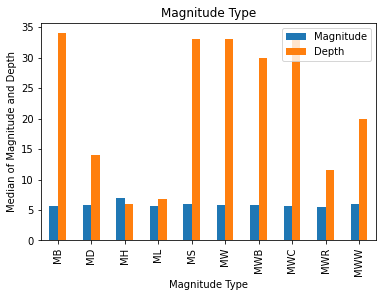

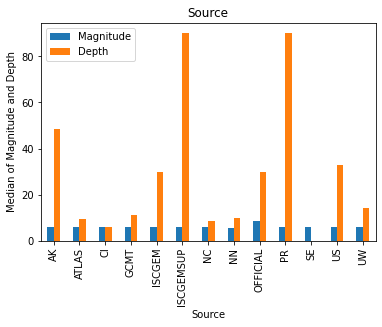

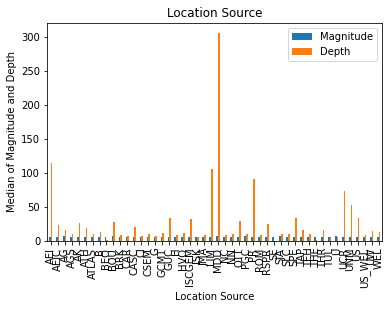

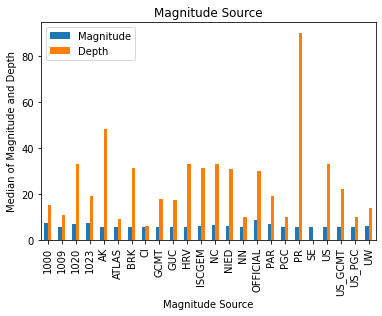

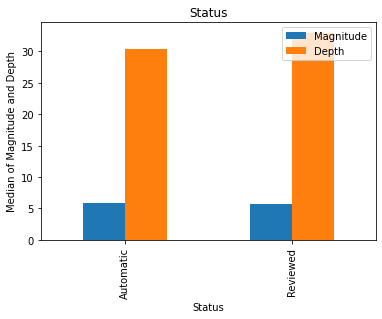

In [18]:
for feature in data.columns:
    if data[feature].dtype=='O':
        data.groupby(feature)['Magnitude','Depth'].median().plot.bar()
        plt.xlabel(feature)
        plt.ylabel('Median of Magnitude and Depth')
        plt.title(feature)
        plt.show()


In [19]:
for feature in data.columns:
    if data[feature].isnull().sum()>0:
        print(feature,data[feature].dtype)

Magnitude Type object
Root Mean Square float64


# Feature Engineering

Missing Values

In [20]:
## Categorical features
for feature in data.columns:
    if data[feature].dtype=='O' and data[feature].isnull().sum()>0:
        print('{}: {}% missing values and total {} missing values out of {}'.format(feature,np.round(data[feature].isnull().mean(),4),data[feature].isnull().sum(),len(data[feature])))

Magnitude Type: 0.0001% missing values and total 3 missing values out of 23412


We can see that the missing percentage is very small and we can eliminate those records. But as our dataset is already small let's replace the missing values with a placeholder "Missing".

In [21]:
for feature in data.columns:
    if data[feature].dtype=='O' and data[feature].isnull().sum()>0:        
        data[feature]=data[feature].fillna('Missing')
        

In [22]:
## Numerical features
## Also we would be creating a new column with _NaN as suffix. 
## This column would have 1 for NaN and 0 for rest. More data.
## Also, we would be replacing the NaN with median of that column.
## Using the median would help avoid outliers.
for feature in data.columns:
    if data[feature].dtype!='O' and data[feature].isnull().sum()>0:
        feature_median=data[feature].median()
        print('{} median: {}'.format(feature,feature_median))
        data[feature+'_NaN']=np.where(data[feature].isnull(),1,0)
        data[feature].fillna(feature_median,inplace=True)



Root Mean Square median: 1.0


In [23]:
data.head(50)

,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,Source,Location Source,Magnitude Source,Status,TimeStamp,Root Mean Square_NaN
0,19.246,145.616,Earthquake,131.6,6.0,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-157630542.0,1
1,1.863,127.352,Earthquake,80.0,5.8,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-157465811.0,1
2,-20.579,-173.972,Earthquake,20.0,6.2,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-157355642.0,1
3,-59.076,-23.557,Earthquake,15.0,5.8,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-157093817.0,1
4,11.938,126.427,Earthquake,15.0,5.8,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-157026430.0,1
5,-13.405,166.629,Earthquake,35.0,6.7,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-156939808.0,1
6,27.357,87.867,Earthquake,20.0,5.9,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-156767255.0,1
7,-13.309,166.212,Earthquake,35.0,6.0,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-156472938.0,1
8,-56.452,-27.043,Earthquake,95.0,6.0,MW,1.0,ISCGEMSUP,ISCGEM,ISCGEM,Automatic,-156428843.0,1
9,-24.563,178.487,Earthquake,565.0,5.8,MW,1.0,ISCGEM,ISCGEM,ISCGEM,Automatic,-156345403.0,1


In [24]:
categorical_features=[]
for feature in data.columns:
    if data[feature].dtype=='O' and feature not in ('TimeStamp'):
        categorical_features.append(feature)

data[categorical_features].head()

,Type,Magnitude Type,Source,Location Source,Magnitude Source,Status
0,Earthquake,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
1,Earthquake,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
2,Earthquake,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
3,Earthquake,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
4,Earthquake,MW,ISCGEM,ISCGEM,ISCGEM,Automatic


In [25]:
## Perform Label Encoding to all categorical features
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

for feature in categorical_features:
    data[feature]=encoder.fit_transform(data[feature])

data[categorical_features].head()

,Type,Magnitude Type,Source,Location Source,Magnitude Source,Status
0,0,5,4,20,11,0
1,0,5,4,20,11,0
2,0,5,4,20,11,0
3,0,5,4,20,11,0
4,0,5,4,20,11,0


In [26]:
data.head()

,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,Source,Location Source,Magnitude Source,Status,TimeStamp,Root Mean Square_NaN
0,19.246,145.616,0,131.6,6.0,5,1.0,4,20,11,0,-157630542.0,1
1,1.863,127.352,0,80.0,5.8,5,1.0,4,20,11,0,-157465811.0,1
2,-20.579,-173.972,0,20.0,6.2,5,1.0,4,20,11,0,-157355642.0,1
3,-59.076,-23.557,0,15.0,5.8,5,1.0,4,20,11,0,-157093817.0,1
4,11.938,126.427,0,15.0,5.8,5,1.0,4,20,11,0,-157026430.0,1


Feature Scaling

In [27]:
## We would be perform Standard Scaler to convert using Standard Normal Distribution

from sklearn.preprocessing import StandardScaler
feature_scaling = [feature for feature in data.columns if feature not in ['Magnitude','Depth']]
scaler=StandardScaler()
scaler.fit(data[feature_scaling])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
## Creating new dataset as transform of Standard Scaler would return a multi-dimensional array

data=pd.concat([data[['Magnitude','Depth']].reset_index(drop=True),pd.DataFrame(scaler.transform(data[feature_scaling]),columns=feature_scaling)],axis=1)
data.head()

,Magnitude,Depth,Latitude,Longitude,Type,Magnitude Type,Root Mean Square,Source,Location Source,Magnitude Source,Status,TimeStamp,Root Mean Square_NaN
0,6.0,131.6,0.583377,0.844368,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.949685,1.692148
1,5.8,80.0,0.006109,0.698849,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.949323,1.692148
2,6.2,20.0,-0.739162,-1.701962,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.949081,1.692148
3,5.8,15.0,-2.017599,-0.503524,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.948506,1.692148
4,5.8,15.0,0.340688,0.691479,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.948358,1.692148


In [29]:
data.to_csv('formatted_data.csv',index=False)

# **Feature Selection**

In [30]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

Y=data[['Magnitude','Depth']]
data.drop(columns=['Magnitude','Depth'],axis=1,inplace=True)
data.head()

,Latitude,Longitude,Type,Magnitude Type,Root Mean Square,Source,Location Source,Magnitude Source,Status,TimeStamp,Root Mean Square_NaN
0,0.583377,0.844368,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.949685,1.692148
1,0.006109,0.698849,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.949323,1.692148
2,-0.739162,-1.701962,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.949081,1.692148
3,-2.017599,-0.503524,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.948506,1.692148
4,0.340688,0.691479,-0.087714,-0.018712,-0.103839,-2.72115,-2.503872,-0.697041,-2.805627,-1.948358,1.692148


Applying feature Selection using Lasso Regression

In [31]:
feature_sel_model=SelectFromModel(Lasso(alpha=0.005,random_state=0))
feature_sel_model.fit(data,Y)

SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [32]:
feature_sel_model.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [33]:
data.columns

Index(['Latitude', 'Longitude', 'Type', 'Magnitude Type', 'Root Mean Square',
       'Source', 'Location Source', 'Magnitude Source', 'Status', 'TimeStamp',
       'Root Mean Square_NaN'],
      dtype='object')

In [34]:
## Split train and test data
from sklearn.model_selection import train_test_split

trainX,testX,trainY,testY=train_test_split(data,Y,test_size=0.1,random_state=23)
trainX.shape,testX.shape,trainY.shape,testY.shape

((21070, 11), (2342, 11), (21070, 2), (2342, 2))

In [40]:
## Visualise on an Map for affected areas
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
temp=pd.read_csv('database.csv')
longitudes = temp["Longitude"].tolist()
latitudes = temp["Latitude"].tolist()
x,y = m(longitudes,latitudes)

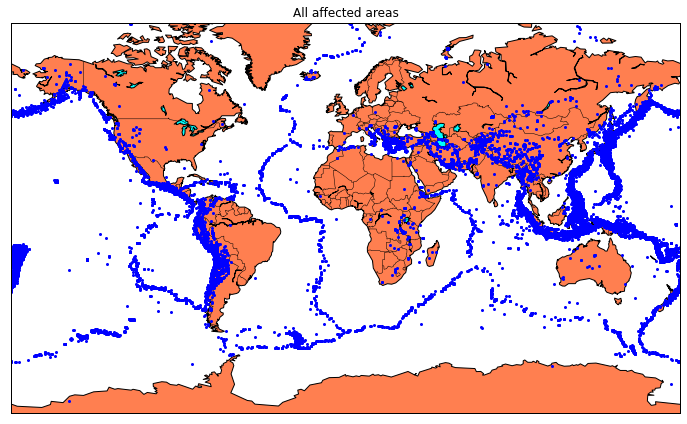

In [41]:
fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

Train the model

In [76]:
from sklearn.ensemble import RandomForestRegressor

Forestmodel=RandomForestRegressor(random_state=42)
Forestmodel.fit(trainX[['TimeStamp','Latitude','Longitude']],trainY)
Forestmodel.predict(testX[['TimeStamp','Latitude','Longitude']])

array([[  5.974 ,  12.841 ],
       [  5.824 ,  63.2044],
       [  5.762 , 318.368 ],
       ...,
       [  5.852 ,  22.1011],
       [  5.733 ,  36.553 ],
       [  6.175 ,  19.858 ]])

In [77]:
Forestmodel.score(testX[['TimeStamp','Latitude','Longitude']],testY)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.834208466964155

In [83]:
## Save the model
import pickle
with open('trainedModel.mdl','wb') as f:
    pickle.dump(Forestmodel,f)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 20, 50, 100, 200, 500]}

grid_obj = GridSearchCV(model, parameters)
grid_fit = grid_obj.fit(trainX[['TimeStamp','Latitude','Longitude']],trainY)
best_fit = grid_fit.best_estimator_
best_fit.predict(testX[['TimeStamp','Latitude','Longitude']])

# Neural Network

In [53]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model=Sequential()
    model.add(Dense(neurons,activation=activation,input_shape=(3,)))
    model.add(Dense(neurons,activation=activation))
    model.add(Dense(2,activation='softmax'))

    model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    return model

In [54]:
from keras.wrappers.scikit_learn import KerasRegressor

In [61]:
model=KerasRegressor(build_fn=create_model,verbose=0)
neurons=[16]
batch_size=[10]
epochs=[10]
activation=['sigmoid','relu']
optimizer=['SGD','Adadelta']
loss=['squared_hinge']

param_grid=dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

In [63]:
grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1)
grid_result=grid.fit(trainX[['TimeStamp','Latitude','Longitude']],trainY)

print('Best: {} using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.0037985400761557874 using {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
-0.003863 (0.000896) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
-0.003799 (0.000880) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
-0.003848 (0.000885) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
-0.003814 (0.000887) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}


In [67]:
model=Sequential()
model.add(Dense(16,activation='relu',input_shape=(3,)))
model.add(Dense(16,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='SGD',loss='squared_hinge',metrics=['accuracy'])

In [69]:
model.fit(trainX[['TimeStamp','Latitude','Longitude']],trainY,batch_size=10,epochs=30,verbose=1,validation_data=(testX[['TimeStamp','Latitude','Longitude']],testY))

Train on 21070 samples, validate on 2342 samples
Epoch 1/30
21070/21070 [==============================] - 2s 107us/step - loss: 0.0038 - accuracy: 0.5813 - val_loss: 0.0039 - val_accuracy: 0.5798
Epoch 2/30
21070/21070 [==============================] - 2s 100us/step - loss: 0.0038 - accuracy: 0.5900 - val_loss: 0.0039 - val_accuracy: 0.5892
Epoch 3/30
21070/21070 [==============================] - 2s 98us/step - loss: 0.0038 - accuracy: 0.6003 - val_loss: 0.0039 - val_accuracy: 0.5995
Epoch 4/30
21070/21070 [==============================] - 2s 100us/step - loss: 0.0038 - accuracy: 0.6121 - val_loss: 0.0039 - val_accuracy: 0.6067
Epoch 5/30
21070/21070 [==============================] - 2s 100us/step - loss: 0.0038 - accuracy: 0.6203 - val_loss: 0.0039 - val_accuracy: 0.6136
Epoch 6/30
21070/21070 [==============================] - 2s 99us/step - loss: 0.0038 - accuracy: 0.6285 - val_loss: 0.0039 - val_accuracy: 0.6243
Epoch 7/30
21070/21070 [==============================] - 2s 99us

In [71]:
[test_loss, test_acc] = model.evaluate(testX[['TimeStamp','Latitude','Longitude']], testY)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

2342/2342 [==============================] - 0s 19us/step
Evaluation result on Test Data : Loss = 0.003900096092824876, accuracy = 0.7587531805038452
